In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union

getcontext().prec = 25
scale_factor = Decimal('1e15')

# Load submissions
saspav_df = pd.read_csv('/home/code/exploration/datasets/santa-2025.csv')
jazivxt_df = pd.read_csv('/home/code/exploration/datasets/submission.csv')

print("Saspav submission shape:", saspav_df.shape)
print(saspav_df.head())
print("\nJazivxt submission shape:", jazivxt_df.shape)
print(jazivxt_df.head())

Saspav submission shape: (20100, 4)
      id                          x                         y  \
0  001_0  s-48.19608619421424577922  s58.77098461521422478882   
1  002_0    s0.15409706962135588659  s-0.03854074269479464826   
2  002_1   s-0.15409706962137284525  s-0.56145925730522405761   
3  003_0    s1.12365581614030096702   s0.78110181599256300888   
4  003_1    s1.23405569584216001644   s1.27599950066375900093   

                         deg  
0   s45.00000000000000000000  
1  s203.62937773065684154972  
2   s23.62937773065679181173  
3  s111.12513229289299943048  
4   s66.37062226934300213088  

Jazivxt submission shape: (20100, 4)
      id                     x                      y                  deg
0  001_0                  s0.0   s-0.3000000000000007  s44.999999999999744
1  002_0   s0.1540970696213643  s-0.03854074269478543  s203.62937773065684
2  002_1  s-0.1540970696213643   s-0.5614592573052146  s23.629377730656792
3  003_0   s0.1857706481046834   s-0.547448842335

In [2]:
# Calculate scores for both submissions
class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (Decimal('0.0') * scale_factor, tip_y * scale_factor),
            (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
            (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
            (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
            (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
            (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
            (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
            (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
            (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

def calculate_score(df):
    df = df.copy()
    df['x'] = df['x'].astype(str).str.strip().str.lstrip('s')
    df['y'] = df['y'].astype(str).str.strip().str.lstrip('s')
    df['deg'] = df['deg'].astype(str).str.strip().str.lstrip('s')
    df[['group_id', 'item_id']] = df['id'].str.split('_', n=2, expand=True)
    
    total_score = Decimal('0')
    side_lengths = {}
    
    for group_id, group_data in df.groupby('group_id'):
        tree_list = [
            ChristmasTree(center_x=row['x'], center_y=row['y'], angle=row['deg'])
            for _, row in group_data.iterrows()
        ]
        all_polygons = [t.polygon for t in tree_list]
        bounds = unary_union(all_polygons).bounds
        side_length = Decimal(max(bounds[2] - bounds[0], bounds[3] - bounds[1])) / scale_factor
        n = int(group_id)
        side_lengths[n] = float(side_length)
        total_score += side_length ** 2 / Decimal(str(n))
    
    return float(total_score), side_lengths

print("Calculating saspav score...")
saspav_score, saspav_sides = calculate_score(saspav_df)
print(f"Saspav score: {saspav_score:.6f}")

print("\\nCalculating jazivxt score...")
jazivxt_score, jazivxt_sides = calculate_score(jazivxt_df)
print(f"Jazivxt score: {jazivxt_score:.6f}")

Calculating saspav score...


Saspav score: 70.658891
\nCalculating jazivxt score...


Jazivxt score: 70.647327


Top 10 N values with biggest score contribution (jazivxt):
  N=1: side=0.813173, contrib=0.661250
  N=2: side=0.949504, contrib=0.450779
  N=3: side=1.142031, contrib=0.434745
  N=5: side=1.443692, contrib=0.416850
  N=4: side=1.290806, contrib=0.416545
  N=7: side=1.673104, contrib=0.399897
  N=6: side=1.548438, contrib=0.399610
  N=9: side=1.867280, contrib=0.387415
  N=8: side=1.755921, contrib=0.385407
  N=15: side=2.384962, contrib=0.379203

Total score: 70.647327


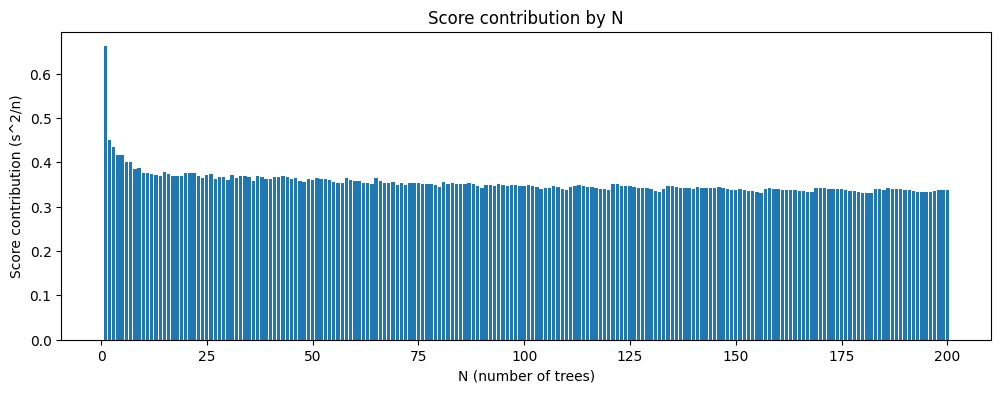

In [3]:
# Compare per-N scores to find where improvements are needed
import matplotlib.pyplot as plt

# Calculate per-N contribution to score
saspav_contrib = {n: (saspav_sides[n]**2)/n for n in saspav_sides}
jazivxt_contrib = {n: (jazivxt_sides[n]**2)/n for n in jazivxt_sides}

# Find where jazivxt is better vs saspav
diff = {n: saspav_contrib[n] - jazivxt_contrib[n] for n in saspav_contrib}

# Top 10 N values with biggest contribution to score
sorted_contrib = sorted(jazivxt_contrib.items(), key=lambda x: x[1], reverse=True)
print("Top 10 N values with biggest score contribution (jazivxt):")
for n, contrib in sorted_contrib[:10]:
    print(f"  N={n}: side={jazivxt_sides[n]:.6f}, contrib={contrib:.6f}")

print(f"\nTotal score: {sum(jazivxt_contrib.values()):.6f}")

# Plot contribution by N
ns = sorted(jazivxt_contrib.keys())
contribs = [jazivxt_contrib[n] for n in ns]
plt.figure(figsize=(12, 4))
plt.bar(ns, contribs)
plt.xlabel('N (number of trees)')
plt.ylabel('Score contribution (s^2/n)')
plt.title('Score contribution by N')
plt.savefig('score_by_n.png', dpi=100)
plt.show()

In [ ]:
# Check the tree shape dimensions
print("Tree shape dimensions:")
print("  Trunk width: 0.15")
print("  Trunk height: 0.2")
print("  Base width: 0.7")
print("  Mid width: 0.4")
print("  Top width: 0.25")
print("  Tip y: 0.8")
print("  Total height: 0.8 + 0.2 = 1.0")
print("  Max width: 0.7")

# For N=1, the optimal bounding box should be the tree itself
# Rotated 45 degrees, the diagonal would be sqrt(0.7^2 + 1^2) = 1.22
# But the actual tree shape is more complex

# Check what the theoretical minimum might be
print(f"\nN=1 current side: {jazivxt_sides[1]:.6f}")
print(f"N=1 contribution: {jazivxt_contrib[1]:.6f}")

# For a single tree, the minimum bounding box depends on rotation
# Let's see what angles are being used
print("\nN=1 tree configuration:")
n1_data = jazivxt_df[jazivxt_df['id'] == '001_0']
print(n1_data)